<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:90%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
<span style="font-family:Georgia, serif;">
<h1 style = "text-align:center;font-size:30px;">Multi-Class Prediction of Cirrhosis Outcomes</h1>  
<h1 style = "text-align:center;font-size:20px;">-2023 Kaggle Playground Series<span class="tocSkip"></span></h1>

<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:150%;
            display:fill;
            border-radius:20px;
            border:#6B8BA0 solid;
            background-color: lightblue;
            line-height: 150%;
            overflow:hidden;
            font-weight:450;"> 
<span style="font-family:Georgia, serif;">
<h1 style = "text-align:center;font-size:30px;">Table of Contents</h1>  

* [Dataset](#section-one)
* [Statistical Summary](#section-two)
* [Data Visualization](#section-three)
    - [Numerical features](#subsection-one)
    - [Categorical features](#subsection-two)
* [Modeling](#section-four)
    - [Feature Engineering](#subsection-three)
    - [Model Selection](#subsection-four)
    - [Optuna Hyperparameter Tunning for Selected Models](#subsection-five)
* [Model Ensemble](#section-five)
* [Submission](#section-six)

<a id="section-one"></a>
<div style="border-radius:20px; border:#6B8BA0 solid; padding: 15px; background-color: lightblue; font-size:100%; text-align:left">

<h1 style = "text-align:center;font-size:20px;">About the dataset.</h1> 


1. **N_Days:** number of days between registration and the earlier of death, transplantation, or study analysis time.

2. **Drug:** type of drug D-penicillamine or placebo.

3. **Age:** The age of the patient (calculated in days).

4. **Sex:** The gender of the patient.

5. **Ascites:**  presence of ascites, either N (No) or Y (Yes).

6. **Hepatomegaly:** presence of hepatomegaly N (No) or Y (Yes).

7. **Spiders:** presence of spiders N (No) or Y (Yes).

8. **Edema:** presence of edema N (no edema), S (edema present without diuretics), or Y (edema despite diuretic therapy) 

9. **Bilirubin:** serum bilirubin (mg/dl).

10. **Cholesterol:** serum cholesterol (mg/dl).

11. **Albumin:** albumin (gm/dl).

12. **Copper:** urine copper (ug/day).
    
13. **Alk_Phos:** alkaline phosphatase (U/liter).

14. **SGOT:** Serum Glutamic-Oxaloacetic Transaminase levels (U/ml).

15. **Tryglicerides:** a type of fat (lipid) found in blood that can increase the risk of heart disease (mg/dL).

16. **Platelets:** platelets per cubic ml/1000.

17. **Prothrombin:** prothrombin time (s).

18. **Stage:** histologic stage of disease (1, 2, 3, or 4).

19. **Status (Target):** status of the patient C (censored), CL (censored due to liver tx), or D (death).

<h1 style = "text-align:left;font-size:10px;">Citation:https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1</h1> 

In [70]:
!pip install mplcyberpunk

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")

import mplcyberpunk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import seaborn as sns
#sns.set(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import optuna

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [2]:
# Read the original dataset
df2 = pd.read_csv('cirrhosis.csv').drop(columns=['ID'],axis=1)

In [3]:
# Read the data
train = pd.read_csv('train.csv').drop(columns=['id'],axis=1)
test = pd.read_csv('test.csv').drop("id",axis=1)

<a id="section-two"></a>
<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:90%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
<span style="font-family:Georgia, serif;">
<h1 style = "text-align:center;font-size:30px;">🔢 Statistical Summary</h1>  

In [4]:
# Take a glance of the data, there is not 
# null values within the dataset
train_info = pd.DataFrame(train.dtypes, columns=['type'])
train_info['null values'] = train.isnull().sum().values 
temp = pd.DataFrame(train.describe(include='all').transpose())
train_info['min'] = temp['min'].values
train_info['max'] = temp['max'].values
pd.merge(train_info,train.head().T,left_index=True,right_index=True)

,type,null values,min,max,0,1,2,3,4
N_Days,int64,0,41.0,4795.0,999,2574,3428,2576,788
Drug,object,0,NaN,NaN,D-penicillamine,Placebo,Placebo,Placebo,Placebo
Age,int64,0,9598.0,28650.0,21532,19237,13727,18460,16658
Sex,object,0,NaN,NaN,M,F,F,F,F
Ascites,object,0,NaN,NaN,N,N,N,N,N
Hepatomegaly,object,0,NaN,NaN,N,N,Y,N,Y
Spiders,object,0,NaN,NaN,N,N,Y,N,N
Edema,object,0,NaN,NaN,N,N,Y,N,N
Bilirubin,float64,0,0.3,28.0,2.3,0.9,3.3,0.6,1.1
Cholesterol,float64,0,120.0,1775.0,316.0,364.0,299.0,256.0,346.0


In [6]:
# Do the same process for testing set, and no
# null values within the dataset either
test_info = pd.DataFrame(test.dtypes, columns=['type'])
test_info['null values'] = test.isnull().sum().values 
temp = pd.DataFrame(test.describe(include='all').transpose())
test_info['min'] = temp['min'].values
test_info['max'] = temp['max'].values
pd.merge(test_info,test.head().T,left_index=True,right_index=True)

,type,null values,min,max,0,1,2,3,4
N_Days,int64,0,41.0,4795.0,3839,2468,51,2330,1615
Drug,object,0,NaN,NaN,D-penicillamine,D-penicillamine,Placebo,D-penicillamine,D-penicillamine
Age,int64,0,9598.0,28650.0,19724,14975,13149,20510,21904
Sex,object,0,NaN,NaN,F,F,F,F,F
Ascites,object,0,NaN,NaN,N,N,N,N,N
Hepatomegaly,object,0,NaN,NaN,Y,N,Y,N,Y
Spiders,object,0,NaN,NaN,N,N,N,N,N
Edema,object,0,NaN,NaN,N,N,Y,N,N
Bilirubin,float64,0,0.3,28.0,1.2,1.1,2.0,0.6,1.4
Cholesterol,float64,0,120.0,1775.0,546.0,660.0,151.0,293.0,277.0


In [134]:
# Split the training dataset into two parts

num_features = []
cate_features = []

for col in train.columns:
    if train[col].dtype == 'object':
        cate_features.append(col)
    else:
        num_features.append(col)
        
print('number of numeric features:', len(num_features))
print('number of categorical features:', len(cate_features))

number of numeric features: 12
number of categorical features: 7


In [135]:
cate_features

['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status']

In [136]:
num_features

['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage']

In [137]:
df2.dropna(axis=0, how='any',inplace=True)

In [108]:
encoders = dict()

for col_name in df2.columns:
    series = df2[col_name]
    label_encoder = LabelEncoder()
    df2[col_name] = pd.Series(
        label_encoder.fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    )
    encoders[col_name] = label_encoder

In [138]:
train = pd.concat([train,df2])
train.index = range(len(train))

<a id="section-three"></a>
<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:90%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
<span style="font-family:Georgia, serif;">
<h1 style = "text-align:center;font-size:30px;">🎨 Data Visualization</h1> 

<a id="subsection-one"></a>
<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:60%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
<span style="font-family:Georgia, serif;">
<h1 style = "text-align:left;font-size:15px;">Next, I'm going to do some simple data visulization for both numerical and categorical features. So let's visualize the numerical features first</h1>  

<Figure size 1200x4000 with 0 Axes>

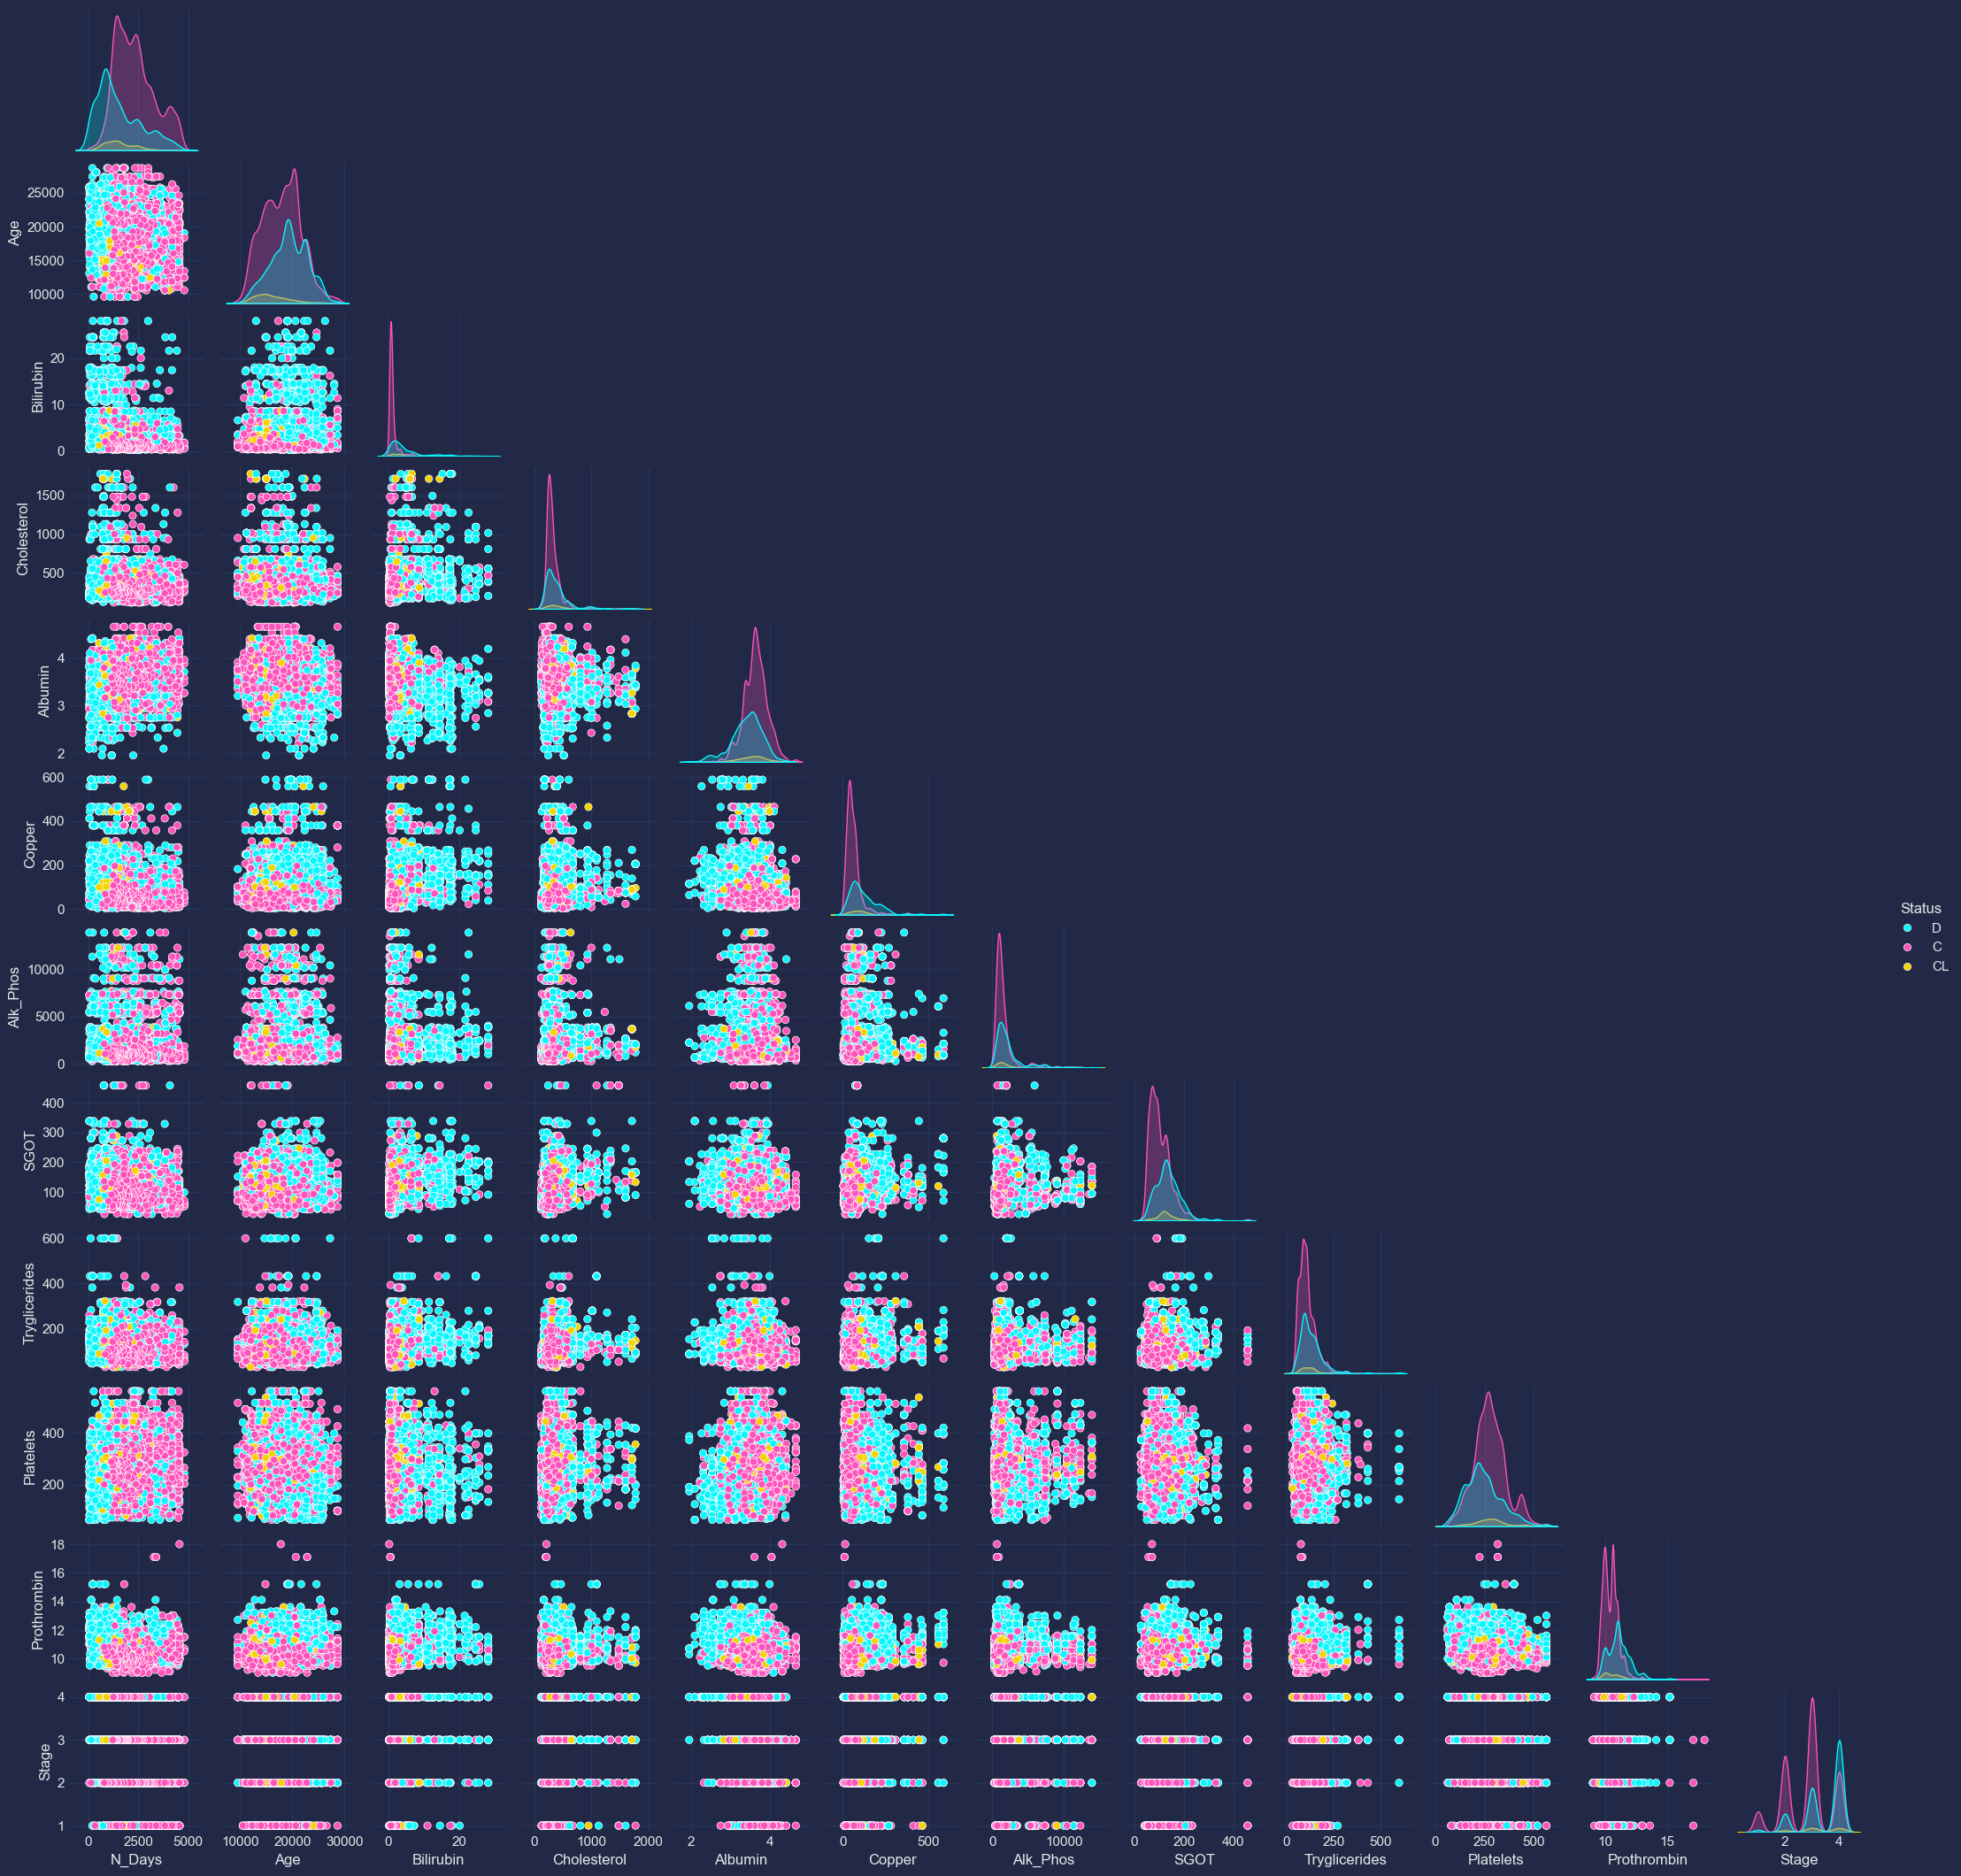

In [139]:
#EDA
# Draw a pair plot for observing the data distribution of each numerical variable

plt.style.use('cyberpunk')
plt.figure(figsize=(12, 40))
sns.pairplot(
    train[num_features+['Status']],
    hue='Status',
    kind="scatter",
    diag_kind='kde',
    height=1.8,
    corner = True
);
plt.show()

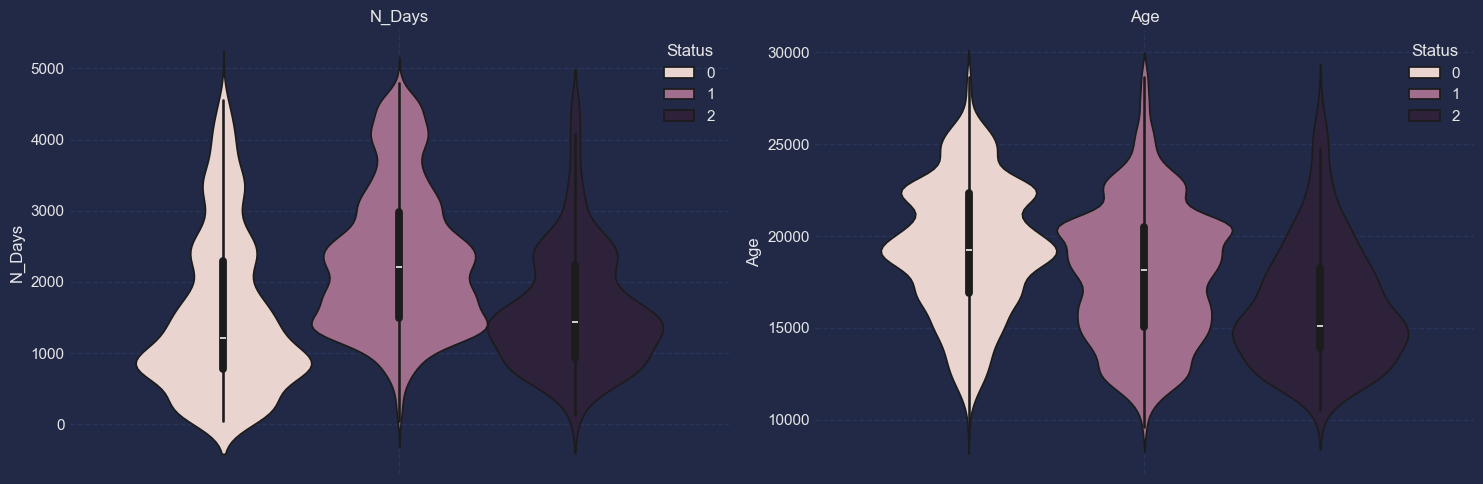

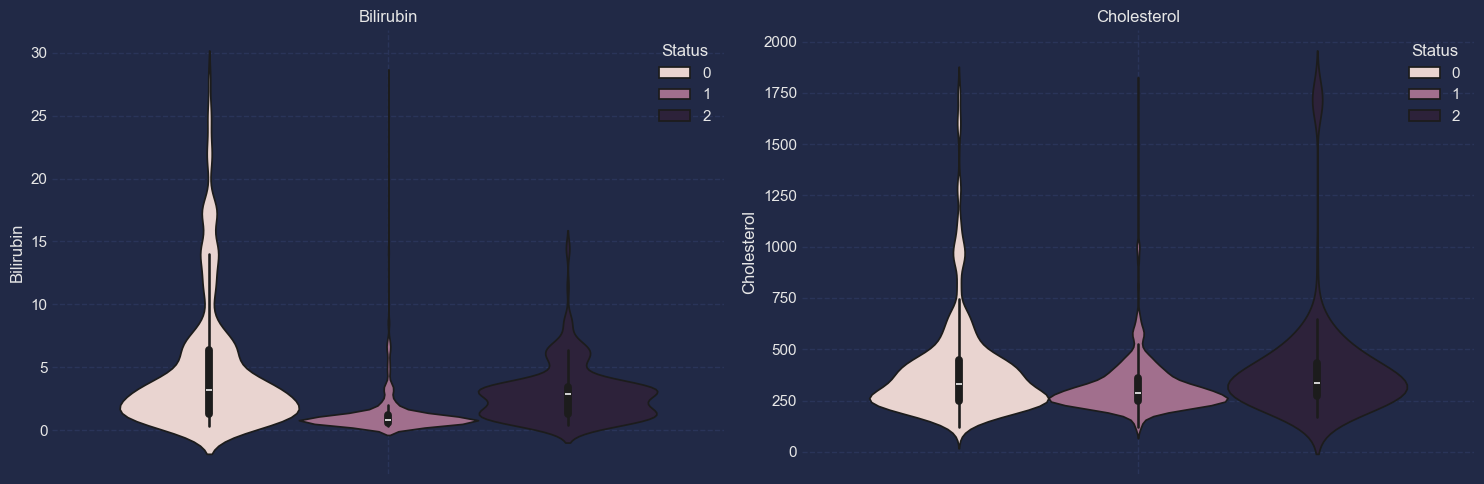

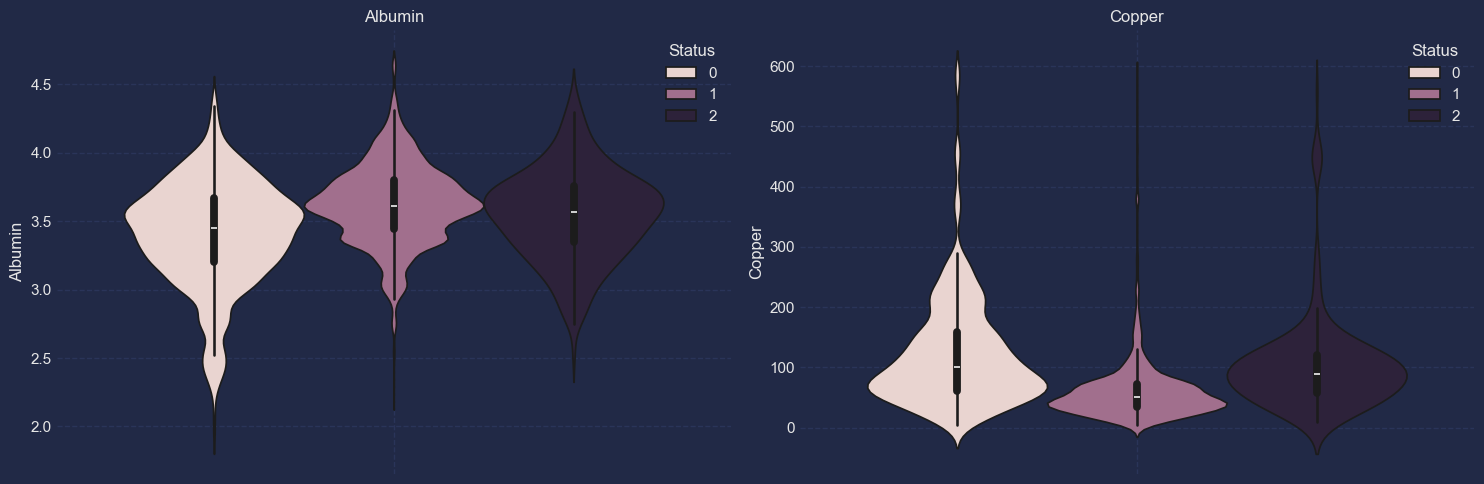

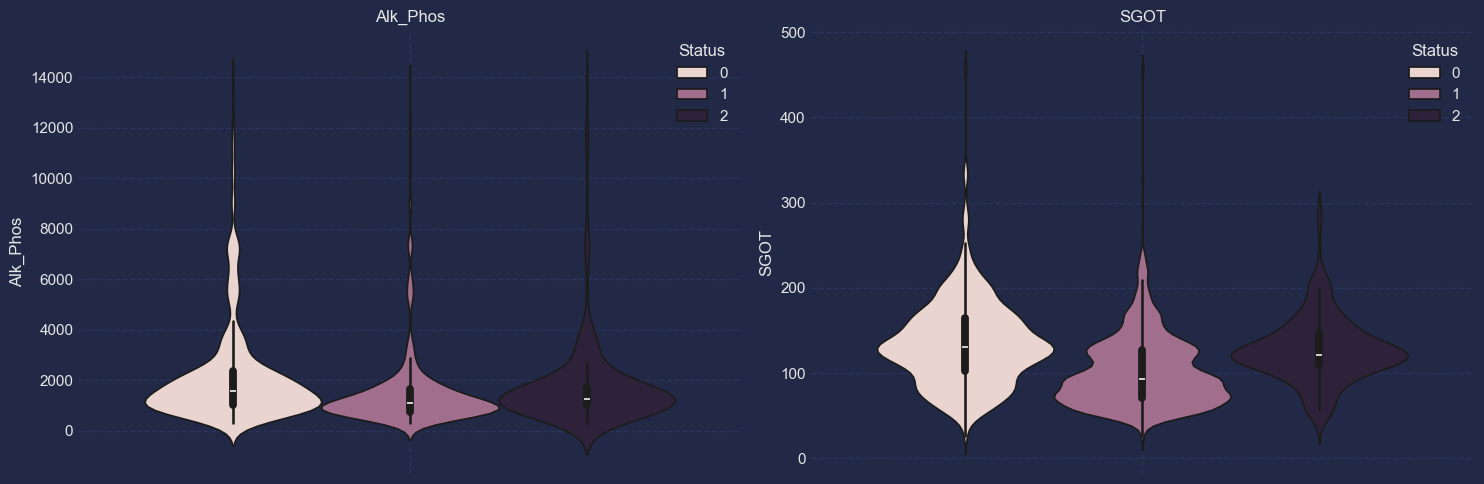

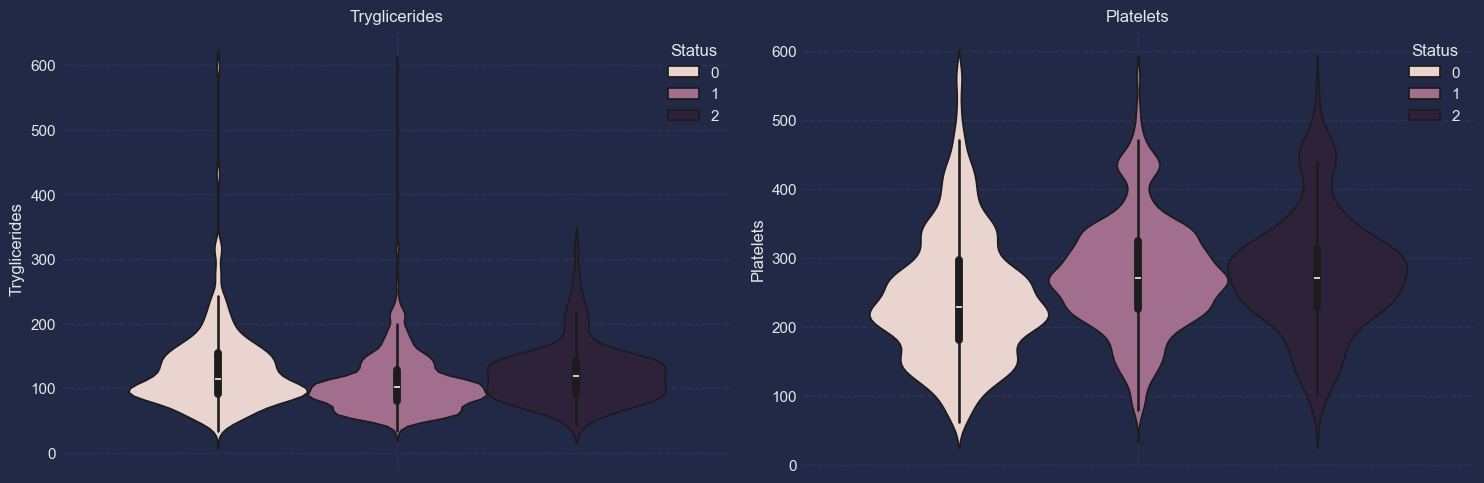

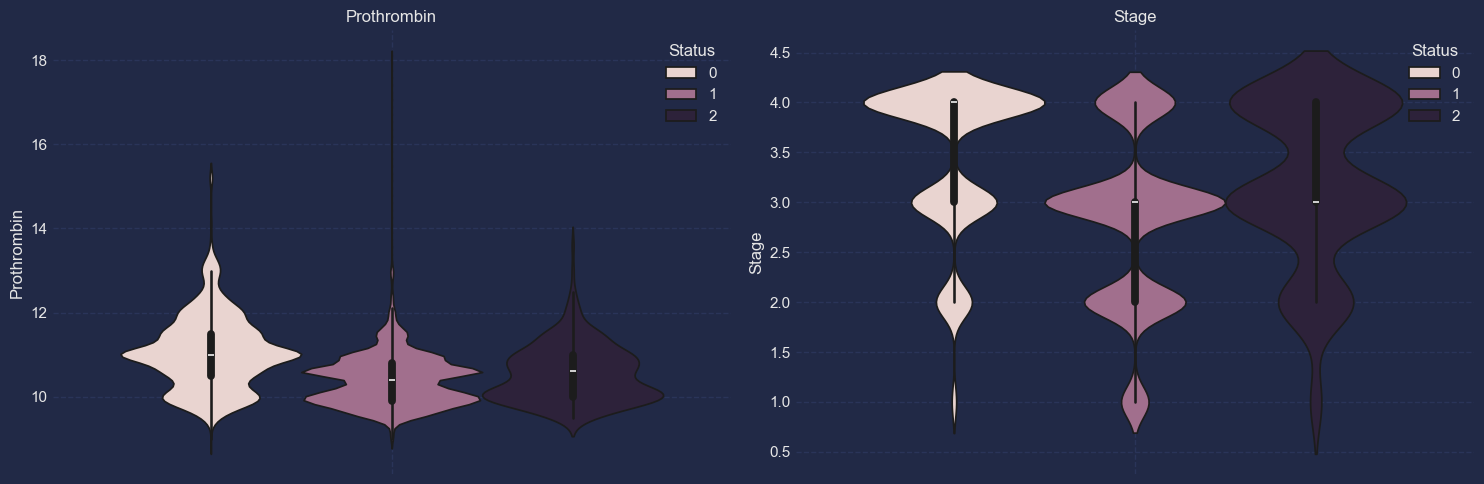

In [80]:
# Violin plot for numerical variables
plt.style.use('cyberpunk')
for col in range(0, len(num_features), 2):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False, sharex=False)
    
    sns.violinplot(
    data=train,
    y=num_features[col],
    orient="v",
    hue='Status',
    ax=axes[0],
    )
    axes[0].set_title(num_features[col])
    
    sns.violinplot(
    data=train,
    y=num_features[col+1],
    orient='v',
    hue='Status',
    ax=axes[1],
    )
    axes[1].set_title(num_features[col+1])
    plt.tight_layout()
    for ax in axes:
        ax.grid(True, which='both', linestyle='--')

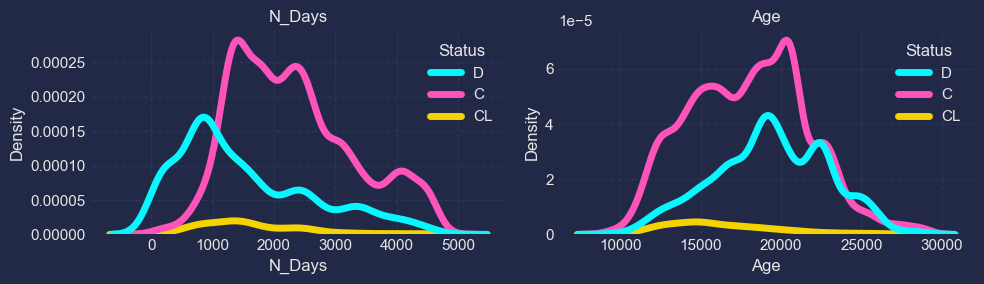

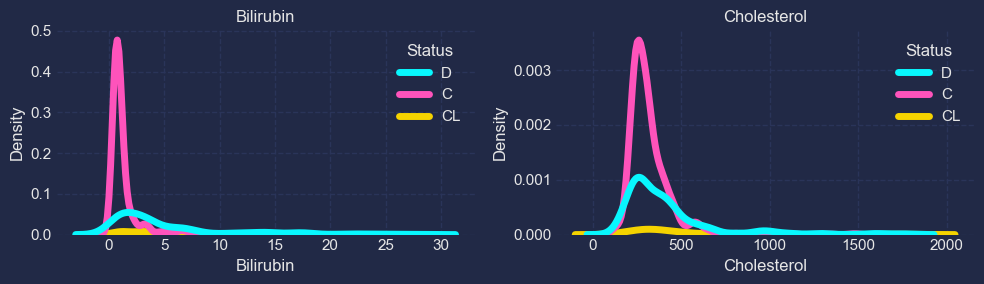

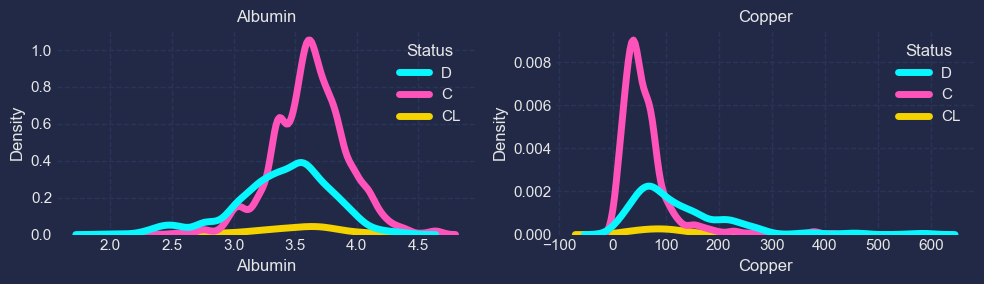

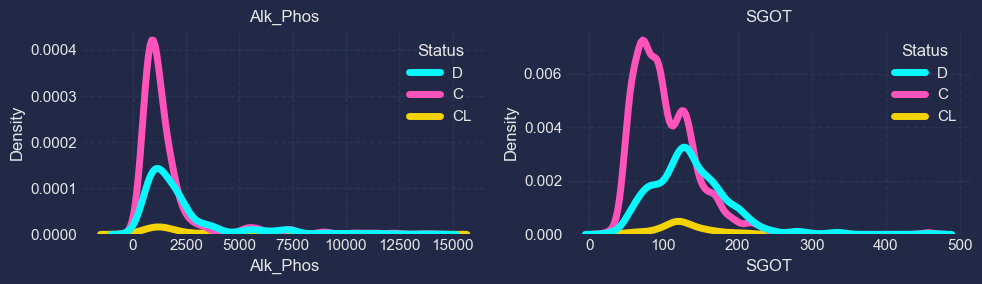

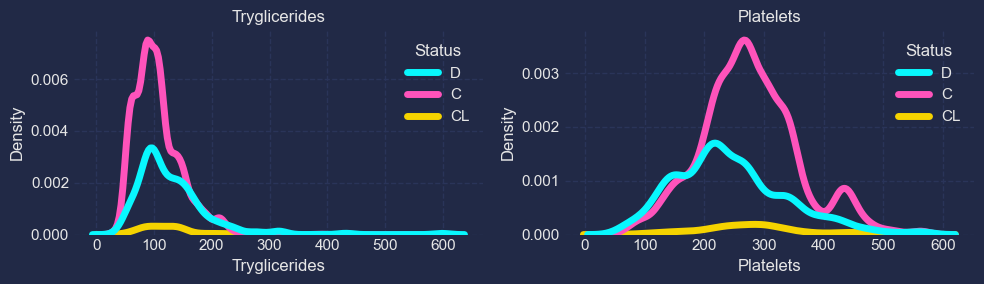

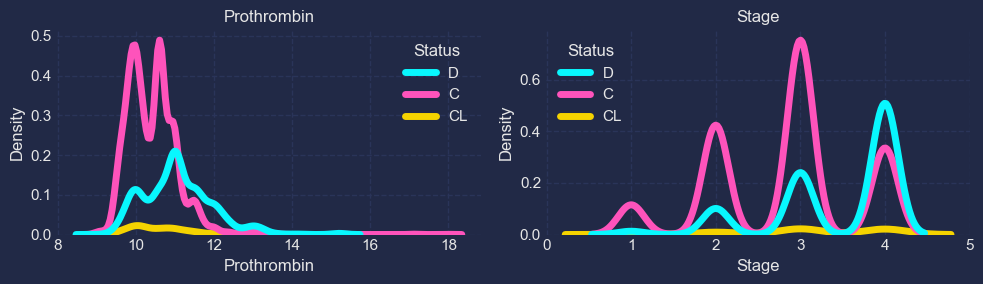

In [10]:
# Visualize the data with kdeplot
plt.style.use('cyberpunk')
for col in range(0, len(num_features), 2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    
    sns.kdeplot(
    data=train,
    x=num_features[col],
    hue='Status',
    ax=axes[0],
    linewidth=5,
    )
    axes[0].set_title(num_features[col])
    
    sns.kdeplot(
    data=train,
    x=num_features[col+1],
    hue='Status',
    ax=axes[1],
    linewidth=5,
    )
    axes[1].set_title(num_features[col+1])
    plt.tight_layout()
    for ax in axes:
        ax.grid(True, which='both', linestyle='--')

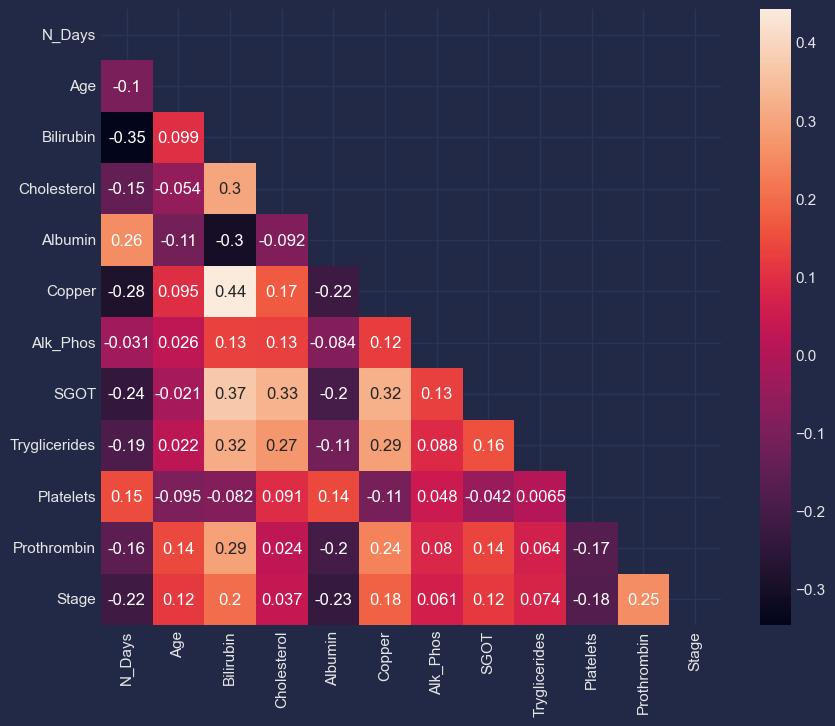

In [11]:
# Plot a heatmap for visualizing the correlation among each numerical variable
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(train[num_features].corr(), dtype=bool))
sns.heatmap(train[num_features].corr(), annot=True, mask=mask)
plt.show()

<a id="subsection-two"></a>
<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:60%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
<span style="font-family:Georgia, serif;">
<h1 style = "text-align:left;font-size:15px;">The graphs created above are for numerical features, and now make some graphs for categorical features for further exploration</h1>  

In [82]:
study_xgb.best_value

0.3710044346109369

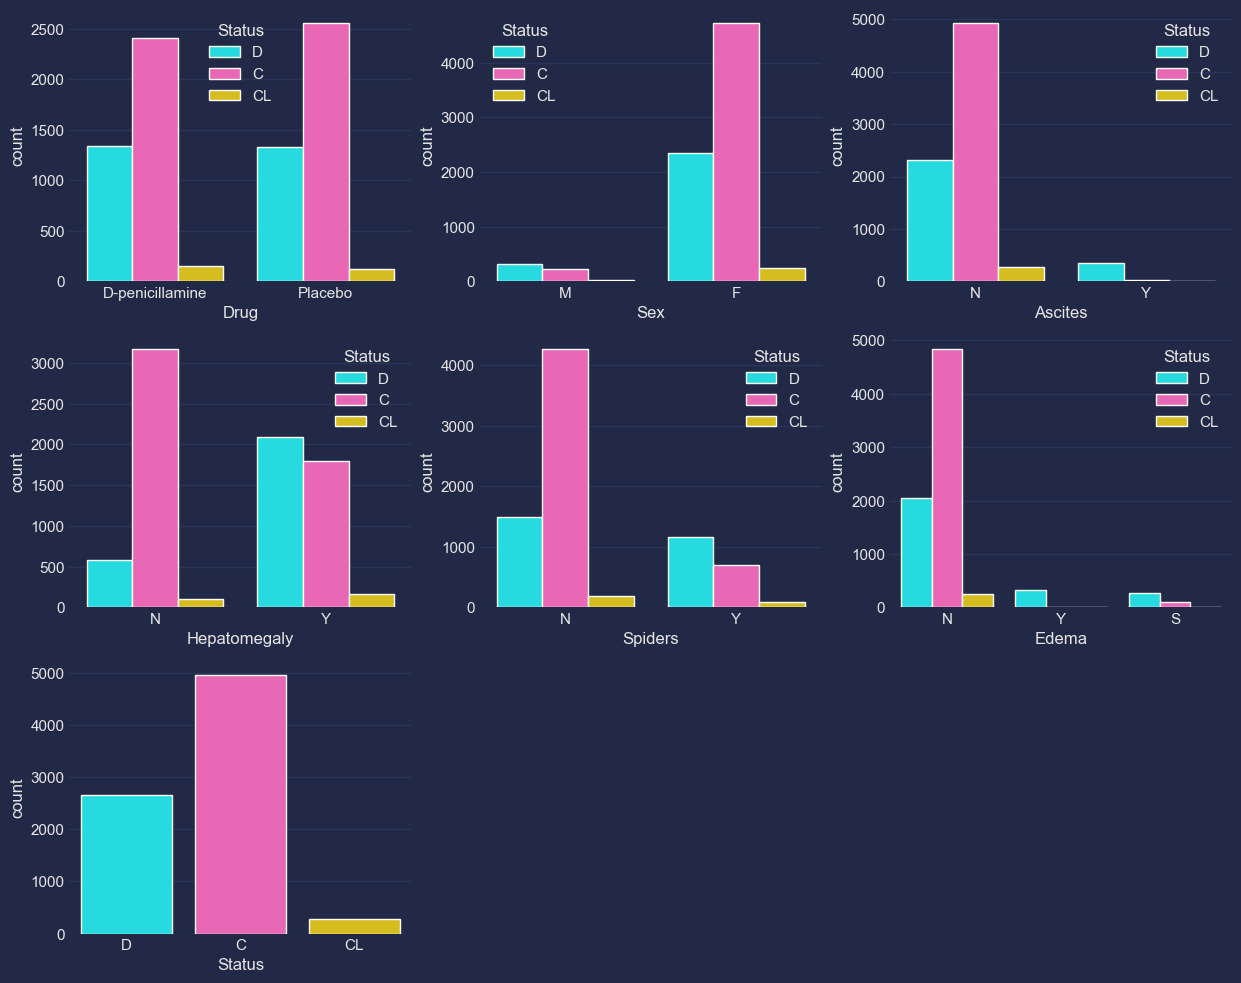

In [12]:
# Draw count plots for each categorical variabels

plt.figure(figsize=(15,12))
for i ,col in enumerate(cate_features ,1):
    plt.subplot(3,3,i)
    sns.countplot(x=col, hue='Status', data=train)
    
plt.show()

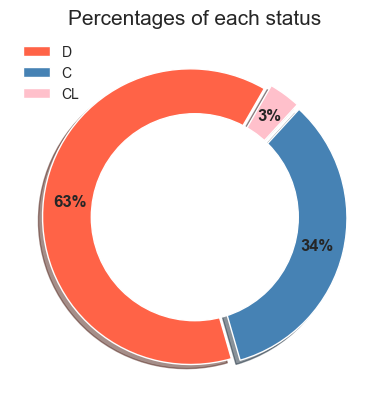

In [13]:
# Draw a pie chart to see the percentage of each status
# in the dataset

sns.set_theme(style="whitegrid")
colors = ['tomato', 'steelblue', 'pink']
patches, texts, autotexts = plt.pie(train['Status'].value_counts(),
                                    autopct='%.0f%%',
                                    colors=colors,
                                    shadow=True,
                                    startangle=60,
                                    pctdistance=0.82,
                                    explode=[0.03, 0.03,0.03])

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

for text in autotexts:
    text.set_fontweight('bold')
    text.set_horizontalalignment('center')

plt.title('Percentages of each status', y=1, fontsize = 15)
plt.legend(labels=train['Status'].unique(), loc='upper left', fontsize=10) 

<a id="section-four"></a>
<a id="subsection-three"></a>
<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:90%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
<span style="font-family:Georgia, serif;">
    <h1 style = "text-align:center;font-size:30px;">⚒️ Modeling</h1>
    <h1 style = "text-align:center;font-size:20px;">*Feature Engineering<span class="tocSkip"></span></h1>

In [153]:
X_test.shape

(1228, 19)

In [141]:
# Encoding the categorical data
# map out the 'Status' label for referencing
status_label = {"D":0, "C":1, "CL":2}
train['Status'] = train['Status'].map(status_label)

# Convert to dummy variables
train = pd.get_dummies(train, columns=train.select_dtypes(include='object').columns, drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=test.select_dtypes(include='object').columns, drop_first=True, dtype=int)

In [142]:
#scores=[]
#random_states = np.arange(start=2000, stop=3000)
#for state in random_states:
#    X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2,random_state=state, stratify=y)
#    xg = XGBClassifier(random_state=42)
#    xg.fit(X_train, Y_train)
#    scores.append(log_loss(Y_test, xg.predict_proba(X_test)))
    
#results = pd.DataFrame({'random_state':random_states, 'score':scores})
#results.sort_values(by='score')

In [152]:
# Split the training data

X = train.drop(columns=['Status'], axis =1).values
y = train['Status'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y,test_size=0.15, random_state = 2668, stratify=y)

<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:100%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
The number of random state does have large impact toward models' outputs. And the numbers '2199','4131','2668' can produce relatively lower log loss scores than other random state numbers.

<a id="subsection-four"></a>
<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:90%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
<span style="font-family:Georgia, serif;">
    <h1 style = "text-align:center;font-size:20px;"> *Model Selection</h1>

In [77]:
study_xgb.best_params

{'booster': 'gbtree',
 'max_depth': 14,
 'learning_rate': 0.03347275064635242,
 'n_estimators': 1028,
 'min_child_weight': 0.36108541002131855,
 'subsample': 0.5992262928584083,
 'colsample_bylevel': 0.3650432426152689,
 'colsample_bytree': 0.17537462441632984,
 'colsample_bynode': 0.10977327303869097,
 'reg_alpha': 0.26255420025531057,
 'reg_lambda': 0.2697669869950342,
 'eval_metric': 'mlogloss'}

In [18]:
# Make a list of classifiers to see which would produce relatively lower log loss score
model_dict = {
    'Hist': HistGradientBoostingClassifier(),
    'SVM' : SVC(probability=True),
    'KNN' : KNeighborsClassifier(n_neighbors=15),
    'GB' : GradientBoostingClassifier(),
    'XGB': XGBClassifier(),
    'DT' : DecisionTreeClassifier(),
    'LGBM' : LGBMClassifier(verbose=-1),
    'RF' : RandomForestClassifier(),
    'Cat' : CatBoostClassifier(logging_level='Silent'),
    'Bayes': GaussianNB()
}

In [19]:
# Use K-Fold method for model selection

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats =1, random_state=42)
model_list, log_loss_list=[],[]
def k_fold_validation(skf,model_dict):
    for model_name, model in model_dict.items():
        log_loss_temp=[]
        for train_index,test_index in skf.split(X, y):
            
            X_train_fold, X_test_fold = X[train_index], X[test_index]
            Y_train_fold, Y_test_fold = y[train_index], y[test_index]
    
            model.fit(X_train_fold,Y_train_fold)
            y_pred = model.predict_proba(X_test_fold)
    
            log_loss_score = log_loss(Y_test_fold, y_pred)
            log_loss_temp.append(log_loss_score)
            
        model_list.append(model_name)
        log_loss_list.append(np.average(log_loss_temp))
    return (pd.DataFrame({'Models': model_list, 'log_loss_score': log_loss_list}))

In [20]:
# Print the result of each model
k_fold_result = k_fold_validation(skf,model_dict)
k_fold_result.sort_values(by='log_loss_score')

,Models,log_loss_score
3,GB,0.450511
6,LGBM,0.462343
8,Cat,0.462737
0,Hist,0.486762
4,XGB,0.501577
7,RF,0.522266
1,SVM,0.660472
2,KNN,1.403929
9,Bayes,1.528276
5,DT,9.547833


<Axes: xlabel='log_loss_score', ylabel='Models'>

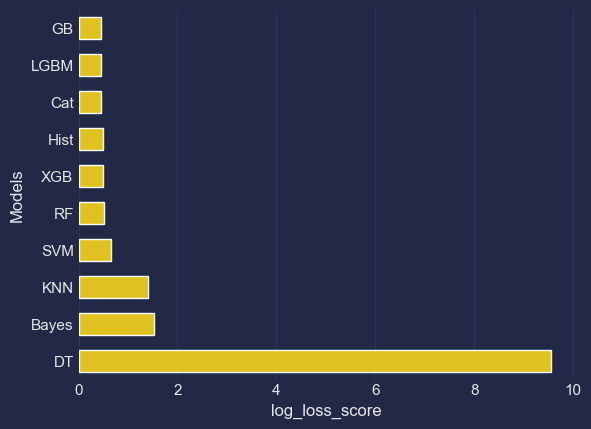

In [22]:
# Visualize the result
plt.style.use('cyberpunk')
sns.barplot(k_fold_result.sort_values(by='log_loss_score'), x='log_loss_score', 
            y='Models',orient='h',color='gold',width=0.6)

<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:100%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
Based on the model selection graph shown above, the Gradient Boosting, LightGBM, CatBoost,
HistGradientBoosting, XGBoost output fairly lower log loss score without parameter tunning.
Therefore, let's use Optuna for hyperparameter tunning for further lowering the log loss scores.

<a id="subsection-five"></a>
<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:90%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
<span style="font-family:Georgia, serif;">
    <h1 style = "text-align:center;font-size:20px;"> *Optuna Hyperparameter Tunning for Selected Models</h1>

In [145]:
# HistGradientBoosting

def objective_hgb(trial):
    
    hgb_params = {
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',30,90),
    'max_iter': trial.suggest_int('max_iter',100,800),
    'max_depth': trial.suggest_int('max_depth', 1, 20),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 80),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 80),
    'l2_regularization': trial.suggest_float('l2_regularization',0.0,2.0),
    'scoring': trial.suggest_categorical('scoring',['neg_log_loss','accuracy']),
    'max_bins': trial.suggest_int('max_bins', 100, 255)
    }
    hgb = HistGradientBoostingClassifier(**hgb_params,random_state=42)
    hgb.fit(X_train,Y_train)
    
    # Show the log loss score directly
    score = log_loss(Y_test, hgb.predict_proba(X_test))
    return score

study_hgb = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_hgb.optimize(objective_hgb, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

[W 2023-12-28 16:24:55,746] Trial 43 failed with parameters: {'learning_rate': 0.06573919399454345, 'max_leaf_nodes': 34, 'max_iter': 286, 'max_depth': 14, 'min_samples_leaf': 36, 'l2_regularization': 0.3899699397998553, 'scoring': 'accuracy', 'max_bins': 151} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/mingzeng/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/mp/hst0s3c53cq66q2w38fmz9zw0000gn/T/ipykernel_77713/2133687522.py", line 17, in objective_hgb
    hgb.fit(X_train,Y_train)
  File "/Users/mingzeng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 687, in fit
    grower.grow()
  File "/Users/mingzeng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_hist_gradient_boosting/grower.py", line 364, in grow
    self.split_next()
  File

KeyboardInterrupt: 

In [159]:
# GradientBoositing

def objective_gb(trial):
    
    gb_params = {
    'criterion': trial.suggest_categorical('criterion',['friedman_mse', 'squared_error']),
    'n_estimators': trial.suggest_int('n_estimators',800,1300),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',20,40),
    'max_depth': trial.suggest_int('max_depth', 1, 20),
    'subsample': trial.suggest_float('subsample',0.1,1.0),
    'min_samples_split': trial.suggest_float('min_samples_split',0.0,1.0),
    'min_samples_leaf': trial.suggest_float('min_samples_leaf',0.0,1.0),
    'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf',0.0,0.5),
    'max_features': trial.suggest_categorical('max_features',['sqrt', 'log2'])
    }
    gb = GradientBoostingClassifier(**gb_params,random_state=42)
    gb.fit(X_train,Y_train)
    
    # Show the log loss score directly
    score = log_loss(Y_test, gb.predict_proba(X_test))
    return score

study_gb = optuna.create_study(direction='minimize')

study_gb.optimize(objective_gb, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

[W 2023-12-28 16:48:49,407] Trial 18 failed with parameters: {'criterion': 'squared_error', 'n_estimators': 1190, 'learning_rate': 0.034595194799384194, 'max_leaf_nodes': 39, 'max_depth': 5, 'subsample': 0.6327584656936739, 'min_samples_split': 0.20879527490566369, 'min_samples_leaf': 0.01202320910074487, 'min_weight_fraction_leaf': 0.16113224440245266, 'max_features': 'sqrt'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/mingzeng/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/mp/hst0s3c53cq66q2w38fmz9zw0000gn/T/ipykernel_77713/3445904360.py", line 18, in objective_gb
    gb.fit(X_train,Y_train)
  File "/Users/mingzeng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py", line 538, in fit
    n_stages = self._fit_stages(
               ^^^^^^^^^^^^^^^^^
  File "/Users/mingzeng/anaconda3/l

KeyboardInterrupt: 

In [161]:
# LGBM Classifier

def objective_lgbm(trial):
    
    lgbm_params = {
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
    'max_depth': trial.suggest_int('max_depth', 1, 30),
    'num_leaves': trial.suggest_int('num_leaves', 20, 100),
  #  'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
    'boosting_type': trial.suggest_categorical('boosting_type',['gbdt', 'dart','rf']),
    'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
    'subsample': trial.suggest_float('subsample',0.1,1.0),
    'subsample_freq': trial.suggest_int('subsample_freq',1,20),
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    'min_child_samples': trial.suggest_int('min_child_samples', 10, 40),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0)
    }
    
    lgbm = LGBMClassifier(**lgbm_params,verbose= -1,random_state=42)
    lgbm.fit(X_train,Y_train)
    
    # Show the log loss score directly
    score = log_loss(Y_test, lgbm.predict_proba(X_test))
    return score

study_lgbm = optuna.create_study(direction='minimize')

study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [35]:
# XGBoost

def objective_xgb(trial):
    
    xgb_params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 1),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1),
        'eval_metric':trial.suggest_categorical('eval_metric', ['mlogloss']),
    }
    xgb = XGBClassifier(**xgb_params,random_state=42)
    xgb.fit(X_train,Y_train)
    
    # Show the log loss score directly
    score = log_loss(Y_test, xgb.predict_proba(X_test))
    return score

study_xgb = optuna.create_study(direction='minimize')

study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
# Catboost

def objective_cat(trial):
    
    cat_params = {
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['MVS','Bayesian']),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'iterations' : trial.suggest_int('iterations', 500, 1100),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',0.1,4.0),
        'bagging_temperature' :trial.suggest_float('bagging_temperature', 1, 3),
        'depth' : trial.suggest_int('depth', 1, 12),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['SymmetricTree','Depthwise']),
        'boosting_type': trial.suggest_categorical('boosting_type',['Plain']),
        'score_function': trial.suggest_categorical('score_function',['Cosine','L2']),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15)
    }
    
    cat = CatBoostClassifier(**cat_params,logging_level='Silent',random_state=42)
    cat.fit(X_train,Y_train)
 
    # Show the log loss score directly
    score = log_loss(Y_test, cat.predict_proba(X_test))
    return score

study_cat = optuna.create_study(direction='minimize')

study_cat.optimize(objective_cat, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

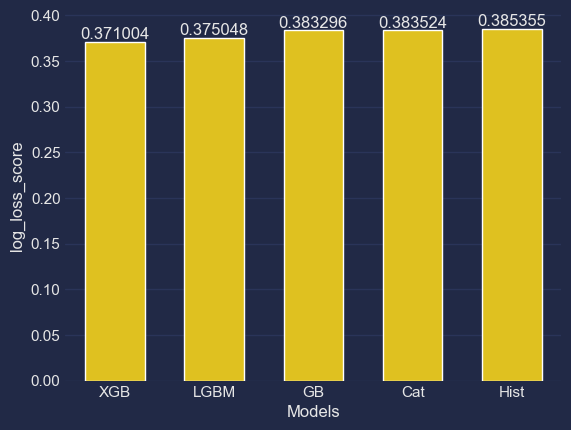

In [69]:
# Visualize the results from each tuned model

tuned_model = {
    'Hist': study_hgb.best_value,
    'GB' : study_gb.best_value,
    'XGB': study_xgb.best_value,
    'LGBM' : study_lgbm.best_value,
    'Cat' : study_cat.best_value
}
tuned_model_df = pd.DataFrame({'Models': list(tuned_model.keys()), 'log_loss_score': list(tuned_model.values())})
ax = sns.barplot(tuned_model_df.sort_values(by='log_loss_score'), y='log_loss_score', 
            x='Models',orient='v',color='gold',width=0.6,dodge=0.5)
for container in ax.containers:
    ax.bar_label(container)

<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:100%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
The scores perform better after Optuna parameter, but the score of HistGradientBoost is slightly higher
than other four models, so the HistGradientBoost classifier should be droped for better model ensembling
performance.

<a id="section-five"></a>
<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:90%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
<span style="font-family:Georgia, serif;">
    <h1 style = "text-align:center;font-size:30px;">🧱 Model Ensemble</h1>

In [37]:
#Stacking
# Since the hgb classifier produces relatively higher log loss
# on training dataset, so just use the other four models for classification

#hgb = HistGradientBoostingClassifier(**study_hgb.best_params,random_state=42)

gb = GradientBoostingClassifier(**study_gb.best_params,random_state=42)

xgb = XGBClassifier(**study_xgb.best_params,random_state=42)

lgbm = LGBMClassifier(**study_lgbm.best_params,random_state=42,verbose=-1)

cat = CatBoostClassifier(**study_cat.best_params,logging_level='Silent',random_state=42)

estimators = [
 #   ('hgb',hgb),
    ('gb',gb),
    ('xgb',xgb),
    ('lgbm',lgbm),
    ('cat', cat)
]

stack_model = StackingClassifier(estimators=estimators, stack_method='predict_proba'
                ,final_estimator=xgb)

In [38]:
stack_model.fit(X_train, Y_train)
stack_predict = stack_model.predict_proba(X_test)
log_loss(Y_test,stack_predict)

0.4776804846474407

In [39]:
#Voting
# Since the hgb classifier produces relatively higher log loss
# on training dataset, so just use the other four models for classification

 hgb = HistGradientBoostingClassifier(**study_hgb.best_params,random_state=42)

gb = GradientBoostingClassifier(**study_gb.best_params,random_state=42)

xgb = XGBClassifier(**study_xgb.best_params,random_state=42)

lgbm = LGBMClassifier(**study_lgbm.best_params,random_state=42,verbose=-1)

cat = CatBoostClassifier(**study_cat.best_params,logging_level='Silent',random_state=42)

estimators = [
 #  ('hgb',hgb),
    ('gb',gb),
    ('xgb',xgb),
    ('lgbm',lgbm),
    ('cat', cat)
]

voting = VotingClassifier(estimators=estimators, voting='soft')

In [40]:
# The voting model has better result the the stacking model
voting.fit(X_train, Y_train)
voting_predict = voting.predict_proba(X_test)
log_loss(Y_test,voting_predict)

0.36989410577632154

<a id="section-six"></a>
<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:90%;
            display:fill;
            border-radius:20px;
            background-color: lightblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
<span style="font-family:Georgia, serif;">
    <h1 style = "text-align:center;font-size:30px;">Result Submission</h1>

In [41]:
# train the voting model with the whole dataset again
voting.fit(X, y)

VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(learning_rate=0.07630521374363446,
                                                         max_depth=20,
                                                         max_features='log2',
                                                         max_leaf_nodes=40,
                                                         min_samples_leaf=0.006044049024718634,
                                                         min_samples_split=0.5251104108597074,
                                                         min_weight_fraction_leaf=0.015594364012391643,
                                                         n_estimators=1112,
                                                         random_state=42,
                                                         subsample=0.7530483058058657)),
                             ('xgb',
                              XGBClassif...
                              LGBMClassifier(colsample_bytree=0.17933362699918073,
                                             learning_rate=0.16643793466683116,
                                             max_depth=18, min_child_samples=22,
                                             min_data_in_leaf=14,
                                             n_estimatores=1323.575915525169,
                                             num_leaves=96, random_state=42,
                                             reg_alpha=0.5553570513729476,
                                             reg_lambda=8.768692226564028,
                                             subsample=0.8450429326106462,
                                             subsample_freq=19, verbose=-1)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x157a73190>)],
                 voting='soft')

In [42]:
submission = pd.read_csv('sample_submission.csv')
submission["Status_C"] =  voting.predict_proba(test)[:,1]
submission["Status_CL"] =  voting.predict_proba(test)[:,2]
submission["Status_D"] =  voting.predict_proba(test)[:, 0]

In [43]:
submission.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.369605,0.018181,0.612214
1,7906,0.446261,0.269654,0.284086
2,7907,0.020910,0.009286,0.969805
3,7908,0.977289,0.002587,0.020124
4,7909,0.892296,0.045187,0.062517


In [44]:
# Export the result
submission.to_csv('submission.csv', index = False)

<a id="subsection-six"></a>
<div style="padding:0px 40px 10px; 
            color:#201E20;
            font-size:110%;
            display:fill;
            border-radius:20px;
            background-color: aliceblue;
            border:#6B8BA0 solid;
            overflow:hidden;
            font-weight:400;"> 
Possible improvement: utilize the original dataset for training; use mode complicated models; add more features
    
Thank You!